In [3]:
import keras
from keras import layers
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import copy
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D
from tqdm import tqdm
import tensorflow as tf

In [4]:
import json
from keras.models import load_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
step_size = 30  #多少天预测一天
feature_num = 24  #多少个features，注意不同indicators时的修改！！！！！！


generator_input = keras.Input(shape=(step_size,feature_num))
x = layers.LSTM(256,return_sequences=True)(generator_input)
#x = layers.Dropout(0.2)(x)
#x = layers.LSTM(25)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units = 128,return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units = 64, return_sequences = True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units = 64, return_sequences = True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units = 32)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
x = layers.LeakyReLU()(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = layers.Input(shape=(step_size+1,1))
y = layers.Conv1D(filters=100, kernel_size=7, activation='relu')(discriminator_input)
y = layers.BatchNormalization()(y)
y = layers.Conv1D(filters=100, kernel_size=5, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.MaxPooling1D(pool_size = 3)(y)
#y = layers.Flatten()(y)
y = layers.Conv1D(filters=160, kernel_size=3, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Conv1D(filters=160, kernel_size=3, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Conv1D(filters=160, kernel_size=3, activation='relu')(y)
y = layers.BatchNormalization()(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(100, activation='relu')(y)
y = layers.Dense(1,activation='sigmoid')(y)
discriminator = keras.models.Model(discriminator_input, y)
discriminator.summary()

# 为了训练稳定，在优化器中使用学习率衰减和梯度限幅（按值）。
#discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
discriminator_optimizer = keras.optimizers.Adam(0.0001, 0.4)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# 将鉴别器（discrimitor）权重设置为不可训练（仅适用于`gan`模型）
discriminator.trainable = False
gan_input = keras.Input(shape=(step_size, feature_num))
gan_output = discriminator(keras.layers.Concatenate(axis=1)([gan_input[:,:,0],generator(gan_input)]))
gan = keras.models.Model(gan_input, gan_output)
#gan_optimizer = keras.optimizers.RMSprop(lr=4e-4, clipvalue=1.0, decay=1e-8)
gan_optimizer = keras.optimizers.Adam(0.0001, 0.4)
gan.compile(optimizer=gan_optimizer, loss='mean_squared_error')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 24)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 256)           287744    
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0     

In [6]:
#step_size = 30  #多少天预测一天
#feature_num = 24  #多少个features，注意不同indicators时的修改！！！！！！

dataset_train = pd.read_csv('AUD_CAD_Processed.csv')
dataset_train.dropna(axis=0, how='any', inplace=True)
dataset_train.drop(['Unnamed: 0'], axis=1, inplace=True)
train_size = 3370 #70% of data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
values = dataset_train.values #67*6
# ensure all data is float
values = values.astype('float32')
training_set_scaled = sc.fit_transform(values[:3371,:])
testing_set_scaled = sc.transform(values[3371:,:])
X_train = []
y_train = []
for i in range(step_size, train_size+1):
    X_train.append(training_set_scaled[i-step_size:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], feature_num))
train_Y = y_train[:,0]

X_test = []
y_test = []
for i in range(step_size, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-step_size:i])
    y_test.append(testing_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], feature_num))
test_Y = y_test[:,0]


In [94]:
least_RMSE = mse_before_scale**(1/2)
least_MAPE = MAPE_O2

In [97]:
least_MAPE

0.004475207

In [144]:
scores = {}
scores['Epoch'] = []
scores['Train_MAPE'] = []
scores['Train_MSE'] = []
scores['Train_RMSE'] = []
scores['Test_MAPE'] = []
scores['Test_MSE'] = []
scores['Test_RMSE'] = []

In [148]:
batch_size = 1
start = 0
#iterations = 61-1
iterations = train_size-step_size+1


for epoch in range(171,181):
    print(epoch)
    final = []
    # 开始训练迭代
    for step in tqdm(range(iterations)):
        temp_X = copy.deepcopy(X_train[step])
        temp_X = temp_X.reshape(batch_size,step_size,feature_num)
        temp_Y = copy.deepcopy(train_Y[step])
        temp_Y = temp_Y.reshape(batch_size,1)
        predictions = generator.predict(temp_X)
        # 训练鉴别器（discrimitor）
        for i in range(25):
            aaa = X_train[step]
            input_f = np.concatenate([np.transpose(np.array([aaa[:,0]])), predictions], 0)
            input_r = np.concatenate([np.transpose(np.array([aaa[:,0]])), temp_Y], 0)
            input = np.concatenate([[input_f],[input_r]])
            labels = np.concatenate([[np.ones((1, 1))], [np.zeros((1, 1))]])   
            d_loss = discriminator.train_on_batch(input, labels)
            # 训练生成器（generator）（通过gan模型，鉴别器（discrimitor）权值被冻结）
        for i in range(5):
            misleading_targets = np.zeros((batch_size, 1))
            a_loss = gan.train_on_batch(temp_X, [misleading_targets])
        final.append(predictions[0])
    final = np.concatenate((np.array(final), y_train[:,-23:]), axis=1)
    final2 = y_train
    int_train_pre = sc.inverse_transform(final)
    int_train_real = sc.inverse_transform(final2)
    MAPE_train = np.mean(np.abs((int_train_real[:,0] - int_train_pre[:,0]) / int_train_real[:,0]))
    #MAPE_O1 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
    train_mse = mean_squared_error(int_train_real[:,0], int_train_pre[:,0])
    train_rmse = train_mse**(1/2)
    final = []
    for step in range(len(test_Y)):  #测试集长度
        temp_X = copy.deepcopy(X_test[step])
        temp_X = temp_X.reshape(batch_size, step_size, feature_num)
        predictions = generator.predict(temp_X)
        final.append(predictions[0])
    print(np.array(final).shape)
    final = np.concatenate((np.array(final), y_test[:,-23:]), axis=1)
    final2 = y_test
    int_test_pre = sc.inverse_transform(final)
    int_test_real = sc.inverse_transform(final2)
    #MAPE_O2 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
    MAPE_test = np.mean(np.abs((int_test_real[:,0] - int_test_pre[:,0]) / int_test_real[:,0]))
    test_mse = mean_squared_error(int_test_real[:,0], int_test_pre[:,0])
    test_rmse = test_mse**(1/2)
    scores['Epoch'].append(epoch)
    scores['Train_MAPE'].append(MAPE_train)
    scores['Train_MSE'].append(train_mse)
    scores['Train_RMSE'].append(train_rmse)
    scores['Test_MAPE'].append(MAPE_test)
    scores['Test_MSE'].append(test_mse)
    scores['Test_RMSE'].append(test_rmse)
    print('Epoch: {:3d} | Train MAPE: {:.4f}| Train RMSE: {:.6f}| Test MAPE: {:.4f} | Test RMSE: {:.6f}'.format(epoch, MAPE_train, train_rmse, MAPE_test, test_rmse))          
    if test_rmse < least_RMSE:
        text_g = '30d_generator_{:d}epoch_deep_best_RMSE'.format(epoch)
        text_d = '30d_discriminator_{:d}epoch_deep_best_RMSE'.format(epoch)
        text_ga = '30d_gan_{:d}epoch_deep_best_RMSE'.format(epoch)
        generator.save(text_g)
        discriminator.save(text_d)
        gan.save(text_ga)
        least_RMSE = test_rmse
    elif MAPE_test < least_MAPE:
        text_g = '30d_generator_{:d}epoch_deep_best_MAPE'.format(epoch)
        text_d = '30d_discriminator_{:d}epoch_deep_best_MAPE'.format(epoch)
        text_ga = '30d_gan_{:d}epoch_deep_best_MAPE'.format(epoch)
        generator.save(text_g)
        discriminator.save(text_d)
        gan.save(text_ga)
        least_MAPE = MAPE_test
for i in range(10):
    scores['Train_MAPE'][i] = scores['Train_MAPE'][i].item()
    scores['Train_MSE'][i] = scores['Train_MSE'][i].item()
    scores['Train_RMSE'][i] = scores['Train_RMSE'][i].item()
    scores['Test_MAPE'][i] = scores['Test_MAPE'][i].item()
    scores['Test_MSE'][i] = scores['Test_MSE'][i].item()
    scores['Test_RMSE'][i] = scores['Test_RMSE'][i].item()
with open('./epoch_171to180.json', 'w') as fp:
          json.dump(scores, fp)

  0%|                                                                                         | 0/3341 [00:00<?, ?it/s]

171


  0%|                                                                                         | 0/3341 [00:00<?, ?it/s]

(1414, 1)
Epoch: 171 | Train MAPE: 0.0049| Train RMSE: 0.006551| Test MAPE: 0.0096 | Test RMSE: 0.010711
172


 13%|██████████▏                                                                    | 433/3341 [06:51<46:02,  1.05it/s]


ResourceExhaustedError:    OOM when allocating tensor with shape[256,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradients/while_grad/while_grad/body/_1/gradients/while_grad/gradients/while/MatMul_1_grad/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Adam/gradients/PartitionedCall_4]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_18869]

Function call stack:
train_function -> train_function -> train_function


In [146]:
least_RMSE

0.0034229004035239074

In [147]:
least_MAPE

0.0027090956

In [118]:
scs = {}
scs['Epoch'] = []
scs['Train_MAPE'] = []
scs['Train_MSE'] = []
scs['Train_RMSE'] = []
scs['Test_MAPE'] = []
scs['Test_MSE'] = []
scs['Test_RMSE'] = []

In [103]:
del scores['Test_RMSE']

scores['Test_RMSE'] = []
mse = np.array(scores['Test_MSE'])

for i in mse:
    scores['Test_RMSE'].append(i**(1/2))
    
with open('./epoch_81to90.json', 'w') as fp:
          json.dump(scores, fp)

TypeError: Object of type float32 is not JSON serializable

In [115]:
#type(scores['Epoch'][0].item())

for i in range(10):
    scores['Train_MAPE'][i] = scores['Train_MAPE'][i].item()
    scores['Train_MSE'][i] = scores['Train_MSE'][i].item()
    scores['Train_RMSE'][i] = scores['Train_RMSE'][i].item()
    scores['Test_MAPE'][i] = scores['Test_MAPE'][i].item()
    scores['Test_MSE'][i] = scores['Test_MSE'][i].item()
    scores['Test_RMSE'][i] = scores['Test_RMSE'][i].item()

with open('./epoch_81to90.json', 'w') as fp:
          json.dump(scores, fp)

In [129]:
with open('./epoch_91to101.json') as fp:
         scs = json.load(fp)
        
        
for i in range(10):
    print('Epoch: {:3d} | Train MAPE: {:.4f}| Train RMSE: {:.6f}| Test MAPE: {:.4f} | Test RMSE: {:.6f}'.format(scs['Epoch'][i], scs['Train_MAPE'][i], scs['Train_RMSE'][i], scs['Test_MAPE'][i], scs['Test_RMSE'][i]))

Epoch:  91 | Train MAPE: 0.0056| Train RMSE: 0.007785| Test MAPE: 0.0061 | Test RMSE: 0.007196
Epoch:  92 | Train MAPE: 0.0051| Train RMSE: 0.007244| Test MAPE: 0.0061 | Test RMSE: 0.007831
Epoch:  93 | Train MAPE: 0.0061| Train RMSE: 0.008550| Test MAPE: 0.0066 | Test RMSE: 0.007590
Epoch:  94 | Train MAPE: 0.0058| Train RMSE: 0.007918| Test MAPE: 0.0044 | Test RMSE: 0.005302
Epoch:  95 | Train MAPE: 0.0055| Train RMSE: 0.007712| Test MAPE: 0.0042 | Test RMSE: 0.006144
Epoch:  96 | Train MAPE: 0.0087| Train RMSE: 0.012334| Test MAPE: 0.0130 | Test RMSE: 0.015151
Epoch:  97 | Train MAPE: 0.0080| Train RMSE: 0.010918| Test MAPE: 0.0093 | Test RMSE: 0.011099
Epoch:  98 | Train MAPE: 0.0067| Train RMSE: 0.008984| Test MAPE: 0.0084 | Test RMSE: 0.009510
Epoch:  99 | Train MAPE: 0.0056| Train RMSE: 0.007465| Test MAPE: 0.0073 | Test RMSE: 0.008236
Epoch: 100 | Train MAPE: 0.0059| Train RMSE: 0.007921| Test MAPE: 0.0029 | Test RMSE: 0.003737


In [87]:
#得到测试集结果
final = []
for step in range(len(test_Y)):  #测试集长度
	temp_X = copy.deepcopy(X_test[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])
print(np.array(final).shape)
final = np.concatenate((np.array(final), y_test[:,-23:]), axis=1)
final2 = y_test
int1 = sc.inverse_transform(final)
int2 = sc.inverse_transform(final2)
#MAPE_O2 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('testing result:',MAPE_O2)

(1414, 1)
testing result: 0.004475207


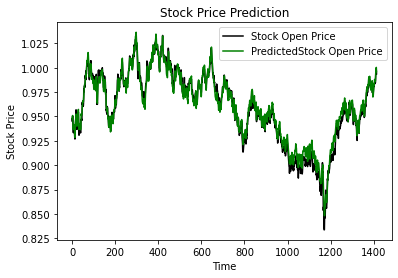

In [88]:
import matplotlib.pyplot as plt
plt.plot(int2[:,0], color = 'black', label = 'Actual Open Price')
plt.plot(int1[:,0], color = 'green', label = 'PredictedStock Open Price')
plt.title('Forex Price Prediction')
plt.xlabel('Time')
plt.ylabel('Forex Price')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error
mse_before_scale = mean_squared_error(int2[:,0], int1[:,0])
print('MSE 80 epoches:',mse_before_scale)

MSE 80 epoches: 2.894014e-05


In [90]:
print('RMSE 80 epoches:',mse_before_scale**(1/2))

RMSE 80 epoches: 0.005379604037502074


In [93]:
from keras.models import load_model

generator.save('30d_generator_80epoch_deep')
discriminator.save('30d_discriminator_80epoch_deep')
gan.save('30d_gan_80epoch_deep')

INFO:tensorflow:Assets written to: 30d_generator_80epoch_deep\assets


INFO:tensorflow:Assets written to: 30d_generator_80epoch_deep\assets


INFO:tensorflow:Assets written to: 30d_discriminator_80epoch_deep\assets


INFO:tensorflow:Assets written to: 30d_discriminator_80epoch_deep\assets


INFO:tensorflow:Assets written to: 30d_gan_80epoch_deep\assets


INFO:tensorflow:Assets written to: 30d_gan_80epoch_deep\assets


In [5]:
# !unzip discriminator_30epoch.zip -d /
# !unzip generator_30epoch.zip -d /
# !unzip gan_30epoch.zip -d /

from keras.models import load_model 

# generator = load_model('generator_1epoch.h5') #打开模型
# discriminator = load_model('discriminator_1epoch.h5') #打开模型

generator = keras.models.load_model("30d_generator_119epoch_deep_best_RMSE")
discriminator = keras.models.load_model("30d_discriminator_119epoch_deep_best_RMSE")
gan = keras.models.load_model("30d_gan_119epoch_deep_best_RMSE")

In [8]:
batch_size = 1
#得到测试集结果
final = []
for step in range(len(test_Y)):  #测试集长度
	temp_X = copy.deepcopy(X_test[step])
	temp_X = temp_X.reshape(batch_size, step_size, feature_num)
	predictions = generator.predict(temp_X)
	final.append(predictions[0])
print(np.array(final).shape)
final = np.concatenate((np.array(final), y_test[:,-23:]), axis=1)
final2 = y_test
int1 = sc.inverse_transform(final)
int2 = sc.inverse_transform(final2)
#MAPE_O2 = np.mean(np.abs((final2[:,0] - final[:,0]) / final2[:,0]))
MAPE_O2 = np.mean(np.abs((int2[:,0] - int1[:,0]) / int2[:,0]))
print('testing result:',MAPE_O2)

(1414, 1)
testing result: 0.002519216


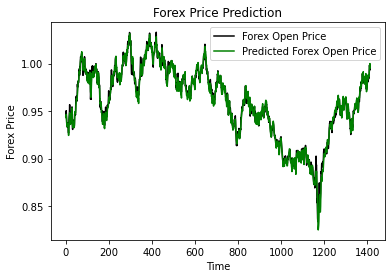

In [9]:
import matplotlib.pyplot as plt
plt.plot(int2[:,0], color = 'black', label = 'Forex Open Price')
plt.plot(int1[:,0], color = 'green', label = 'Predicted Forex Open Price')
plt.title('Forex Price Prediction')
plt.xlabel('Time')
plt.ylabel('Forex Price')
plt.legend()
plt.show()

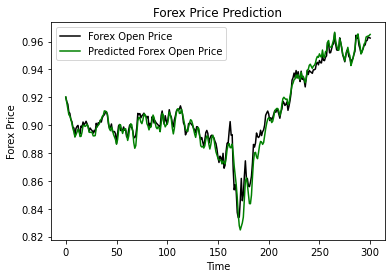

In [10]:
import matplotlib.pyplot as plt
plt.plot(int2[1000:1301,0], color = 'black', label = 'Forex Open Price')
plt.plot(int1[1000:1301,0], color = 'green', label = 'Predicted Forex Open Price')
plt.title('Forex Price Prediction')
plt.xlabel('Time')
plt.ylabel('Forex Price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
mse_before_scale = mean_squared_error(int2[:,0], int1[:,0])
print('MSE 30 epoches:',mse_before_scale)

MSE 30 epoches: 5.213089e-05
